<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal
import pywt

<h1> Fitlering Functions

In [2]:
def apply_butterband_filter(input_df):
    df = input_df.copy()
    for col in df.columns:
        df[col] = filter_df_col(df, col)
        
    return df

def filter_df_col(df, col):
    fs = 512.0
    lowcut = 12.0
    highcut = 25.0
    
    vals = df[col].values
    return butter_bandpass_filter(vals, lowcut, highcut, fs)

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * 50    # amplify data
    y = filtfilt(b, a, data)
    return y

In [3]:
def wavelet_dwt(df):
    return pywt.dwt(df.values, 'db5')

def pca_and_inverse(df):
    pca = PCA(0.80).fit(df)
    components = pca.transform(df)
    return pca.inverse_transform(components)
    
def pca_feature_selection(df):
    pca = PCA(1).fit(df)
    return pca.transform(df)

In [4]:
record_export_folder = 'recordings'
# keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']
keep_cols = ['P7', 'O1', 'O2', 'P8'] # ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=0)

def trim_cols(df):
    return df[keep_cols]

def filter_data(df):
#     df = apply_butterband_filter(df)
    return wavelet_dwt(df)

<h1> Data from 4 Sensors

In [5]:
df = trim_cols(load_df('checkerboard_recording_sultan_for_50_seconds_{}.csv'.format(0)))
approx, decomp = filter_data(df)
decomp = np.asarray(decomp)

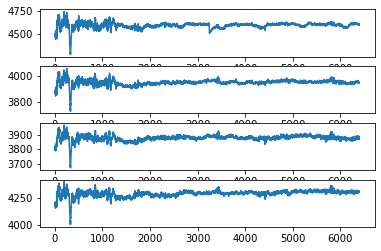

In [6]:
subplot = 0
fig, axs = plt.subplots(4)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

<h1> Wavlet Decomposition 

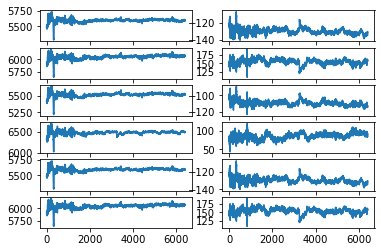

In [7]:
bands = approx.shape[1]
subplot = 0
axis = 0
fig, axs = plt.subplots(bands, 2)
for dataset in [approx, decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA Seperating Approx and Discrete

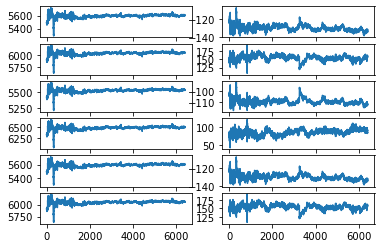

In [8]:
bands = approx.shape[1]
subplot = 0
axis = 0
pca_approx = pca_and_inverse(approx) 
pca_decomp = pca_and_inverse(decomp)
fig, axs = plt.subplots(bands, 2)
for dataset in [pca_approx, pca_decomp]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA

In [9]:
subplot = 0
axis = 0
full = np.concatenate((approx, decomp), axis=1)
pca_full = pca_and_inverse(full)
bands = pca_full.shape[1]

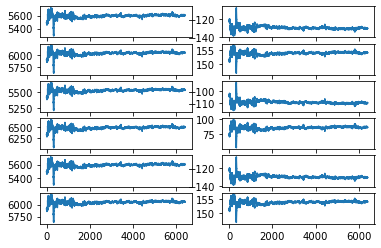

In [10]:
fig, axs = plt.subplots(int(bands / 2), 2)
for col in range(bands):
    axs[subplot, axis].plot(pca_full[:,col])
    subplot += 1
    if subplot == int(bands / 2):
        subplot = 0
        axis += 1

<h1> Training Data

In [11]:
from sklearn.preprocessing import minmax_scale

In [12]:
seconds_to_check = 1
seconds_per_recording = 50
interval_range = int(128 * seconds_to_check)
data_points = int(seconds_per_recording / seconds_to_check)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

def scale_and_normalize(data):
#     print(data.shape)
    for col in range(data.shape[1]):
        data[:,col] = minmax_scale(data[:,col])
    return data
#     return minmax_scale(data)

In [13]:
targets = range(0, 9)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('checkerboard_recording_sultan_for_50_seconds_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    pca_approx = pca_and_inverse(approx) 
    pca_decomp = pca_and_inverse(decomp)
    total_data = np.concatenate((pca_approx, pca_decomp), axis=1)
#     total_data = pca_approx
#     total_data = pca_decomp
    total_data = scale_and_normalize(total_data)
    train_x = split_to_training_data(total_data)
    train_y = create_target_data(train_x, target)
    if target == targets[0]:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [14]:
total_train_x.shape

(450, 12, 128)

In [15]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.25)

In [16]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU, BatchNormalization, LayerNormalization, ActivityRegularization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

In [17]:
def create_model():
    model = Sequential()
    model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

#     model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

    model.add(LSTM(32, input_shape=(train_x.shape[1:]), return_sequences=False))
    model.add(Dropout(0.5))
#     model.add(ActivityRegularization(l2=0.01))
#     model.add(BatchNormalization())

#     model.add(Dense(32))

    model.add(Dense(9, activation="softmax"))
    
    return model

In [18]:
EPOCHS = 200
BATCH_SIZE = 16
NAME= "models\BEST"

In [19]:
model = create_model()
    
opt = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

callbacks = [
#     TensorBoard(f"logs\LSTM-{int(time.time())}"),
    ReduceLROnPlateau(patience=12, factor=0.8),
    EarlyStopping(patience=30),
    ModelCheckpoint(filepath=f"models\Best", monitor='val_loss', verbose=2, save_weights_only=True, save_best_only=True, mode='min')
]
    
history = model.fit(train_x,
                    train_y,
                    batch_size= BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data=(validation_x, validation_y), 
                    callbacks=callbacks)

Epoch 1/200
22/22 [==============================] - ETA: 0s - loss: 2.2525 - acc: 0.1217   
Epoch 00001: val_loss improved from inf to 2.20743, saving model to models\Best
22/22 [==============================] - 1s 49ms/step - loss: 2.2525 - acc: 0.1217 - val_loss: 2.2074 - val_acc: 0.1062
Epoch 2/200
22/22 [==============================] - ETA: 0s - loss: 2.2035 - acc: 0.1128
Epoch 00002: val_loss improved from 2.20743 to 2.20337, saving model to models\Best
22/22 [==============================] - 0s 8ms/step - loss: 2.2035 - acc: 0.1128 - val_loss: 2.2034 - val_acc: 0.0796
Epoch 3/200
22/22 [==============================] - ETA: 0s - loss: 2.1977 - acc: 0.1335
Epoch 00003: val_loss improved from 2.20337 to 2.20046, saving model to models\Best
22/22 [==============================] - 0s 8ms/step - loss: 2.1977 - acc: 0.1335 - val_loss: 2.2005 - val_acc: 0.0885
Epoch 4/200
12/22 [===============>..............] - ETA: 0s - loss: 2.1948 - acc: 0.1042
Epoch 00004: val_loss did not i

Epoch 30/200
12/22 [===============>..............] - ETA: 0s - loss: 1.2115 - acc: 0.6146
Epoch 00030: val_loss did not improve from 0.95413
22/22 [==============================] - 0s 6ms/step - loss: 1.1776 - acc: 0.6083 - val_loss: 0.9953 - val_acc: 0.6549
Epoch 31/200
12/22 [===============>..............] - ETA: 0s - loss: 1.2022 - acc: 0.5677
Epoch 00031: val_loss did not improve from 0.95413
22/22 [==============================] - 0s 6ms/step - loss: 1.1674 - acc: 0.5905 - val_loss: 0.9757 - val_acc: 0.6106
Epoch 32/200
12/22 [===============>..............] - ETA: 0s - loss: 1.0751 - acc: 0.6146
Epoch 00032: val_loss improved from 0.95413 to 0.93534, saving model to models\Best
22/22 [==============================] - 0s 7ms/step - loss: 1.0731 - acc: 0.6320 - val_loss: 0.9353 - val_acc: 0.7788
Epoch 33/200
12/22 [===============>..............] - ETA: 0s - loss: 1.1123 - acc: 0.5990
Epoch 00033: val_loss improved from 0.93534 to 0.92089, saving model to models\Best
22/22 [==

Epoch 60/200
12/22 [===============>..............] - ETA: 0s - loss: 0.9242 - acc: 0.6875
Epoch 00060: val_loss did not improve from 0.69674
22/22 [==============================] - 0s 6ms/step - loss: 0.9282 - acc: 0.6973 - val_loss: 0.7267 - val_acc: 0.7434
Epoch 61/200
12/22 [===============>..............] - ETA: 0s - loss: 0.9160 - acc: 0.6875
Epoch 00061: val_loss did not improve from 0.69674
22/22 [==============================] - 0s 6ms/step - loss: 0.8653 - acc: 0.7300 - val_loss: 0.8136 - val_acc: 0.6903
Epoch 62/200
12/22 [===============>..............] - ETA: 0s - loss: 0.9172 - acc: 0.6979
Epoch 00062: val_loss did not improve from 0.69674
22/22 [==============================] - 0s 6ms/step - loss: 0.9294 - acc: 0.6914 - val_loss: 0.9670 - val_acc: 0.6018
Epoch 63/200
12/22 [===============>..............] - ETA: 0s - loss: 1.0437 - acc: 0.6510
Epoch 00063: val_loss did not improve from 0.69674
22/22 [==============================] - 0s 6ms/step - loss: 0.9793 - acc: 

Epoch 91/200
22/22 [==============================] - ETA: 0s - loss: 0.7511 - acc: 0.7478
Epoch 00091: val_loss improved from 0.59478 to 0.58948, saving model to models\Best
22/22 [==============================] - 0s 9ms/step - loss: 0.7511 - acc: 0.7478 - val_loss: 0.5895 - val_acc: 0.8496
Epoch 92/200
21/22 [===========================>..] - ETA: 0s - loss: 0.7961 - acc: 0.7262
Epoch 00092: val_loss improved from 0.58948 to 0.55377, saving model to models\Best
22/22 [==============================] - 0s 8ms/step - loss: 0.7956 - acc: 0.7270 - val_loss: 0.5538 - val_acc: 0.8584
Epoch 93/200
21/22 [===========================>..] - ETA: 0s - loss: 0.7641 - acc: 0.7560
Epoch 00093: val_loss did not improve from 0.55377
22/22 [==============================] - 0s 7ms/step - loss: 0.7642 - acc: 0.7567 - val_loss: 0.5618 - val_acc: 0.8584
Epoch 94/200
22/22 [==============================] - ETA: 0s - loss: 0.7138 - acc: 0.7715
Epoch 00094: val_loss did not improve from 0.55377
22/22 [==

Epoch 122/200
21/22 [===========================>..] - ETA: 0s - loss: 0.5988 - acc: 0.8393
Epoch 00122: val_loss did not improve from 0.46911
22/22 [==============================] - 0s 7ms/step - loss: 0.5972 - acc: 0.8398 - val_loss: 0.5272 - val_acc: 0.8407
Epoch 123/200
21/22 [===========================>..] - ETA: 0s - loss: 0.6585 - acc: 0.7976
Epoch 00123: val_loss did not improve from 0.46911
22/22 [==============================] - 0s 7ms/step - loss: 0.6569 - acc: 0.7982 - val_loss: 0.5509 - val_acc: 0.8230
Epoch 124/200
19/22 [========================>.....] - ETA: 0s - loss: 0.5770 - acc: 0.8355
Epoch 00124: val_loss did not improve from 0.46911
22/22 [==============================] - 0s 8ms/step - loss: 0.5869 - acc: 0.8309 - val_loss: 0.4876 - val_acc: 0.8761
Epoch 125/200
21/22 [===========================>..] - ETA: 0s - loss: 0.5643 - acc: 0.8304
Epoch 00125: val_loss did not improve from 0.46911
22/22 [==============================] - 0s 7ms/step - loss: 0.5638 - a

Epoch 153/200
22/22 [==============================] - ETA: 0s - loss: 0.5174 - acc: 0.8279
Epoch 00153: val_loss did not improve from 0.44281
22/22 [==============================] - 0s 6ms/step - loss: 0.5174 - acc: 0.8279 - val_loss: 0.7003 - val_acc: 0.7788
Epoch 154/200
22/22 [==============================] - ETA: 0s - loss: 0.8121 - acc: 0.7418
Epoch 00154: val_loss did not improve from 0.44281
22/22 [==============================] - 0s 6ms/step - loss: 0.8121 - acc: 0.7418 - val_loss: 0.9753 - val_acc: 0.7699
Epoch 155/200
12/22 [===============>..............] - ETA: 0s - loss: 0.7460 - acc: 0.7708
Epoch 00155: val_loss did not improve from 0.44281
22/22 [==============================] - 0s 6ms/step - loss: 0.6881 - acc: 0.7834 - val_loss: 0.4981 - val_acc: 0.8850
Epoch 156/200
12/22 [===============>..............] - ETA: 0s - loss: 0.5491 - acc: 0.8125
Epoch 00156: val_loss did not improve from 0.44281
22/22 [==============================] - 0s 6ms/step - loss: 0.5246 - a

22/22 [==============================] - ETA: 0s - loss: 0.4276 - acc: 0.8783
Epoch 00184: val_loss did not improve from 0.41178
22/22 [==============================] - 0s 6ms/step - loss: 0.4276 - acc: 0.8783 - val_loss: 0.4517 - val_acc: 0.8938
Epoch 185/200
12/22 [===============>..............] - ETA: 0s - loss: 0.4189 - acc: 0.9167
Epoch 00185: val_loss did not improve from 0.41178
22/22 [==============================] - 0s 6ms/step - loss: 0.4196 - acc: 0.9021 - val_loss: 0.4199 - val_acc: 0.9027
Epoch 186/200
21/22 [===========================>..] - ETA: 0s - loss: 0.4255 - acc: 0.8869
Epoch 00186: val_loss did not improve from 0.41178
22/22 [==============================] - 0s 7ms/step - loss: 0.4271 - acc: 0.8872 - val_loss: 0.4644 - val_acc: 0.8938
Epoch 187/200
21/22 [===========================>..] - ETA: 0s - loss: 0.3962 - acc: 0.9048
Epoch 00187: val_loss did not improve from 0.41178
22/22 [==============================] - 0s 7ms/step - loss: 0.3953 - acc: 0.9050 - v

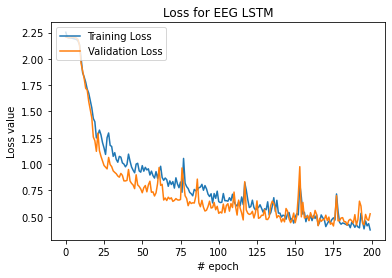

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss for EEG LSTM')
plt.ylabel('Loss value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

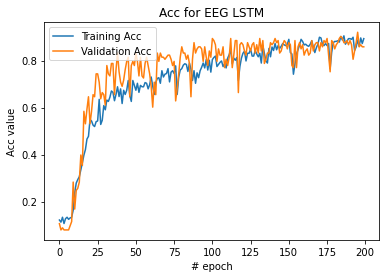

In [21]:
plt.plot(history.history['acc'], label='Training Acc')
plt.plot(history.history['val_acc'], label='Validation Acc')
plt.title('Acc for EEG LSTM')
plt.ylabel('Acc value')
plt.xlabel('# epoch')
plt.legend(loc="upper left")
plt.show()

In [22]:
model = create_model()
    
opt = tf.keras.optimizers.Adam()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt, metrics=['acc'])

In [23]:
model.load_weights(f"models\Best")

In [24]:
train_x.shape

(337, 12, 128)

In [34]:
pred = model.predict(train_x[0].reshape(-1, train_x.shape[1], train_x.shape[2]))

In [35]:
pred

array([[3.3189676e-04, 4.2085871e-03, 6.9821896e-03, 2.4181621e-03,
        2.3798265e-04, 2.1329962e-03, 5.0884534e-02, 6.4253420e-02,
        8.6855030e-01]], dtype=float32)

In [36]:
np.argmax(pred)

8

In [37]:
train_y[:10]

array([8, 7, 1, 2, 1, 1, 6, 1, 3, 7])

In [39]:
model.save_weights('models\model.h5')
model_json = model.to_json()
with open('models\model.json', "w") as json_file:
    json_file.write(model_json)

In [29]:
model.save('models\LSTM') 

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


KeyboardInterrupt: 